# Initialize

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from classy_sz import Class


Metal device set to: Apple M1 Pro


2023-04-07 05:20:53.563747: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-04-07 05:20:53.563868: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [2]:
#plotting settings
font = {'family':'STIXGeneral'}
axislabelfontsize='large'
matplotlib.rc('font', **font)

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})


In [3]:
def tSZ(hmf='T10',
        press_profile='B12',
        concentration='B13', 
       zmin=0.005, zmax=2.,
       Mmin=1e11, Mmax=1e16, 
       xout=4, B=1.25, P0_B12=11, out='tot'):
    
    """function to easily compute the tSZ power spectrum using class_sz.
    
    Input:
    
    hmf: halo mass function --'T10','T08200m','B15' (default:'T10'-- Tinker+2010 )
    press_profile: pressure profile -- 'P13','A10','B12'(default:'B12'-- Battaglia+2012)
    concentration: concentration parameter --'D08','K10','DM14' (default: 'B13'-- Bhattacharya+2013)
    zmin: minimum redshift 
    zmax: maximum redshift 
    Mmin: minimum mass
    Mmax: maximum mass 
    xout: outer radius/R_200c (default: 4)
    B: HSE bias ((1-b)^-1; b set to 0.2 in Planck+2013)
    out: "all" if you want to return 1-h & 2-h terms in addition to total, 
    "tot" if you just want the total tSZ power spectrum
    
    Output:
    
    if out is set to 'tot':
    ell and total tSZ power spectrum
    
    if out is set to 'all':
    
    ell, 1-halo, 2-halo, total tSZ power spectrum
    """
    
    
    # the parameters needed for cosmology:
    # use the last column of Planck 2018 (https://arxiv.org/pdf/1807.06209.pdf) Table 2
    # TT,TE,EE+lowE+lensing+BAO
    cosmo_params = {
    'omega_b': 0.02242,
    'omega_cdm':  0.11933,
    'H0': 67.66, # use H0 because this is what is used by the emulators.
    'tau_reio': 0.0561,
    'ln10^{10}A_s': 3.047,
    'n_s': 0.9665,
    
    'k_pivot': 0.05,
    'N_ncdm': 1,
    'N_ur': 2.0328,
    'm_ncdm': 0.06}

    
    tSZ_dict={'output':'tSZ_1h, tSZ_2h',
        
        'ell_max' : 9950.0,
        'ell_min' : 50,
        'dlogell': 0.1,
        
        # mass function/pressure profile/concentration prescriptions 
        'mass function' : hmf,
        'hm_consistency': 0,             
        'pressure profile': press_profile, 
        'concentration parameter': concentration,
    
        #P(k) settings for mass function
        'k_per_decade_class_sz':80.,
        'k_min_for_pk_class_sz':1e-4,
        'k_max_for_pk_class_sz':7.,
        
        #integration precision settings
        'ndim_redshifts' :80,
        'redshift_epsrel': 1e-4,
        'redshift_epsabs': 1e-100,
        'mass_epsrel':1e-4,
        'mass_epsabs':1e-100,
        
        #redshift and mass bounds
        'z_min' : zmin,
        'z_max' : zmax,
        'M_min' : Mmin*cosmo_params['H0']/100.,
        'M_max' : Mmax*cosmo_params['H0']/100.,
        
        # pressure profile params:
        
        'delta for electron pressure':'200c',
        # 'n_z_dydz' : 500,

        
        'x_outSZ': xout,
        'use_fft_for_profiles_transform':1,
        'truncate_wrt_rvir': 0,
        'n_k_pressure_profile' :50, # this is l/ls # default 80
        'n_m_pressure_profile' :30, # default: 100, decrease for faster
        'n_z_pressure_profile' :30, # default: 100, decrease for faster

        'k_min_gas_pressure_profile' : 1e-3, # l/ls hence no need for very extreme values...
        'k_max_gas_pressure_profile' : 1e2, 
             
             
             }
    
    if press_profile =='B12':
        
        tSZ_dict['P0_B12']=P0_B12
    
    elif press_profile=='A10' or press_profile=='P13':
        tSZ_dict['B']=B
    
    M = Class()
    M.set(cosmo_params)
    M.set(tSZ_dict)
    M.compute_class_szfast()
    cl_yy= M.cl_sz()
    
    cl_ell=np.array(cl_yy['ell'])
    cl_1h=np.array(cl_yy['1h'])
    cl_2h=np.array(cl_yy['2h'])
    
    cl_tot=cl_1h+cl_2h
    
    if out=='all':
        
        return cl_ell, cl_1h, cl_2h, cl_tot
    
    elif out=='tot':
        
        return cl_ell, cl_tot
    


# 1-halo, 2-halo, total


In [4]:
%%time
cl_yy_ell_T10_B13_B12, cl_yy_1h_T10_B13_B12, cl_yy_2h_T10_B13_B12, cl_yy_tot_T10_B13_B12=tSZ(out='all')

CPU times: user 3.6 s, sys: 161 ms, total: 3.76 s
Wall time: 667 ms


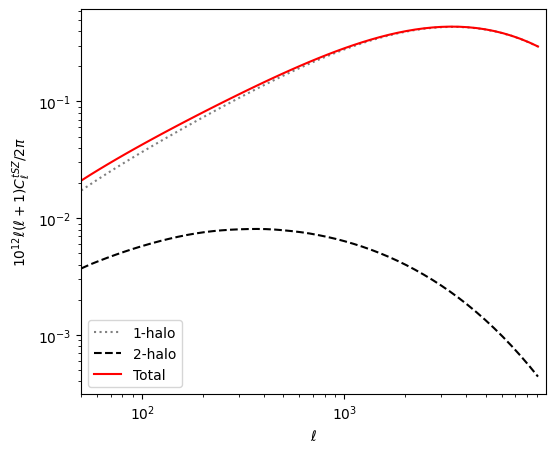

In [5]:
plt.figure(figsize=(6,5))
plt.xscale('log')
plt.yscale('log')

plt.plot(cl_yy_ell_T10_B13_B12, cl_yy_1h_T10_B13_B12, c='grey', label='1-halo', ls=':')
plt.plot(cl_yy_ell_T10_B13_B12, cl_yy_2h_T10_B13_B12, c='black', label='2-halo', ls='--')
plt.plot(cl_yy_ell_T10_B13_B12, cl_yy_tot_T10_B13_B12, c='red', label='Total')

plt.xlim([50, 9950])
plt.ylabel(r'$10^{12}\ell(\ell+1)C_{\ell}^{tSZ}/2\pi$')
plt.xlabel('$\ell$')
plt.legend(loc='lower left')
plt.savefig('figures/tSZ_1h_2h.pdf')

# different halo mass functions, pressure profiles & concentration parameters 

CPU times: user 18.5 s, sys: 957 ms, total: 19.4 s
Wall time: 4.11 s


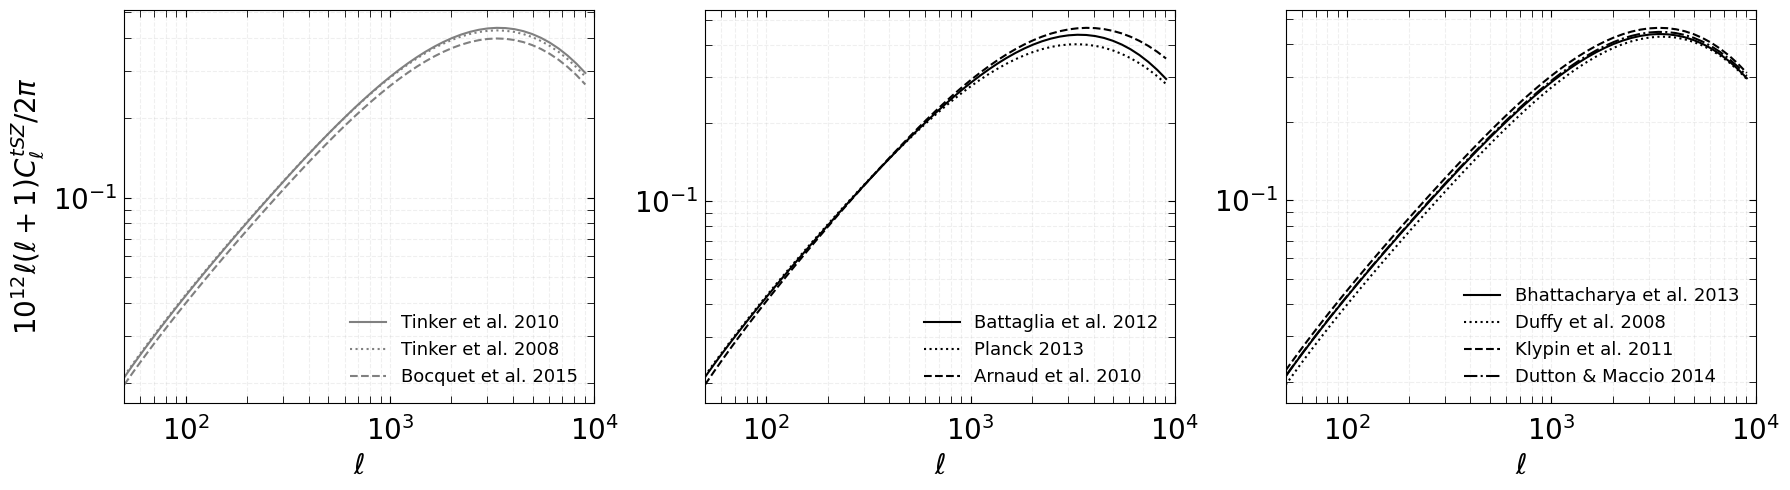

In [9]:
%%time 

label_size = 20
title_size = 20
legend_size = 13
handle_length = 1.5
linestyles=np.array([':','--','-.'])
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(18,5))

#different mass functions
hmf_plot_labels=np.array([r'Tinker et al. 2008',r'Bocquet et al. 2015'])
hmf_params=np.array(['T08200m','B15'])


#different pressure profiles
pp_plot_labels=np.array(['Planck 2013','Arnaud et al. 2010'])
pp_params=np.array(['P13','A10'])

#different concentration parameters
conc_plot_labels=np.array(['Duffy et al. 2008','Klypin et al. 2011','Dutton & Maccio 2014'])
conc_params=np.array(['D08','K10','DM14'])


#plot settings
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlim([50,1e4])
ax1.tick_params(axis = 'x',which='both',length=5,direction='in', pad=10)
ax1.tick_params(axis = 'y',which='both',length=5,direction='in', pad=5)
ax1.xaxis.set_ticks_position('both')
ax1.yaxis.set_ticks_position('both')
plt.setp(ax1.get_yticklabels(), rotation='horizontal', fontsize=label_size)
plt.setp(ax1.get_xticklabels(), fontsize=label_size)
ax1.grid( visible=True, which="both", alpha=0.2, linestyle='--')
ax1.set_xlabel(r'$\ell$', fontsize=label_size)
ax1.set_ylabel(r'$10^{12}\ell(\ell+1)C_{\ell}^{tSZ}/2\pi$', fontsize=label_size)

#plot while chaning mass function
ax1.plot(cl_yy_ell_T10_B13_B12, cl_yy_tot_T10_B13_B12, label='Tinker et al. 2010', c='grey')

for i in range(len(hmf_params)):
    
    #change pressure profile
    cl_yy_ell, cl_yy_tot=tSZ(hmf=hmf_params[i])
    
    ax1.plot(cl_yy_ell, cl_yy_tot, label=hmf_plot_labels[i], c='grey', ls=linestyles[i])
ax1.legend(fontsize=legend_size,frameon=False)

#plot settings
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_xlim([50,1e4])
ax2.tick_params(axis = 'x',which='both',length=5,direction='in', pad=10)
ax2.tick_params(axis = 'y',which='both',length=5,direction='in', pad=5)
ax2.xaxis.set_ticks_position('both')
ax2.yaxis.set_ticks_position('both')
plt.setp(ax2.get_yticklabels(), rotation='horizontal', fontsize=label_size)
plt.setp(ax2.get_xticklabels(), fontsize=label_size)
ax2.grid(visible=True, which="both", alpha=0.2, linestyle='--')
ax2.set_xlabel(r'$\ell$', fontsize=label_size)

#plot while chaning pressure profile
ax2.plot(cl_yy_ell_T10_B13_B12, cl_yy_tot_T10_B13_B12, label='Battaglia et al. 2012', c='black')
for j in range(len(pp_params)):
    
    #change pressure profile
    if pp_params[j]=='A10' or pp_params[j]=='P13' :
        cl_yy_ell, cl1h,cl2h,cl_yy_tot=tSZ(press_profile=pp_params[j], B=1.7,out='all')
        ax2.plot(cl_yy_ell, cl_yy_tot, label=pp_plot_labels[j], c='black', ls=linestyles[j])
        # ax2.plot(cl_yy_ell, cl1h, c='k', ls=linestyles[j],lw=0.7)
        # ax2.plot(cl_yy_ell, cl2h, c='k', ls=linestyles[j],lw=0.7)
ax2.legend(fontsize=legend_size,frameon=False)

#plot settings
ax3.set_xscale('log')
ax3.set_yscale('log')
ax3.set_xscale('log')
ax3.set_yscale('log')
ax3.set_xlim([50,1e4])
ax3.tick_params(axis = 'x',which='both',length=5,direction='in', pad=10)
ax3.tick_params(axis = 'y',which='both',length=5,direction='in', pad=5)
ax3.xaxis.set_ticks_position('both')
ax3.yaxis.set_ticks_position('both')
plt.setp(ax3.get_yticklabels(), rotation='horizontal', fontsize=label_size)
plt.setp(ax3.get_xticklabels(), fontsize=label_size)
ax3.grid(visible=True, which="both", alpha=0.2, linestyle='--')
ax3.set_xlabel(r'$\ell$', fontsize=label_size)

#plot while chaning concentration parameter
ax3.plot(cl_yy_ell_T10_B13_B12, cl_yy_tot_T10_B13_B12, label='Bhattacharya et al. 2013', c='k')
for k in range(len(conc_params)):

    #change concentration parameter
    
    cl_yy_ell, cl1h,cl2h,cl_yy_tot=tSZ(concentration=conc_params[k],out='all')
       
    ax3.plot(cl_yy_ell, cl_yy_tot, label=conc_plot_labels[k], c='k', ls=linestyles[k])
    # ax3.plot(cl_yy_ell, cl1h, c='k', ls=linestyles[k],lw=0.7)
    # ax3.plot(cl_yy_ell, cl2h, c='k', ls=linestyles[k],lw=0.7)

ax3.legend(fontsize=legend_size,frameon=False)

fig.tight_layout()
plt.savefig('figures/tSZ_hmf_pp_conc.pdf')
    

## different masses, redshifts and radii

CPU times: user 36.1 s, sys: 1.35 s, total: 37.5 s
Wall time: 6.58 s


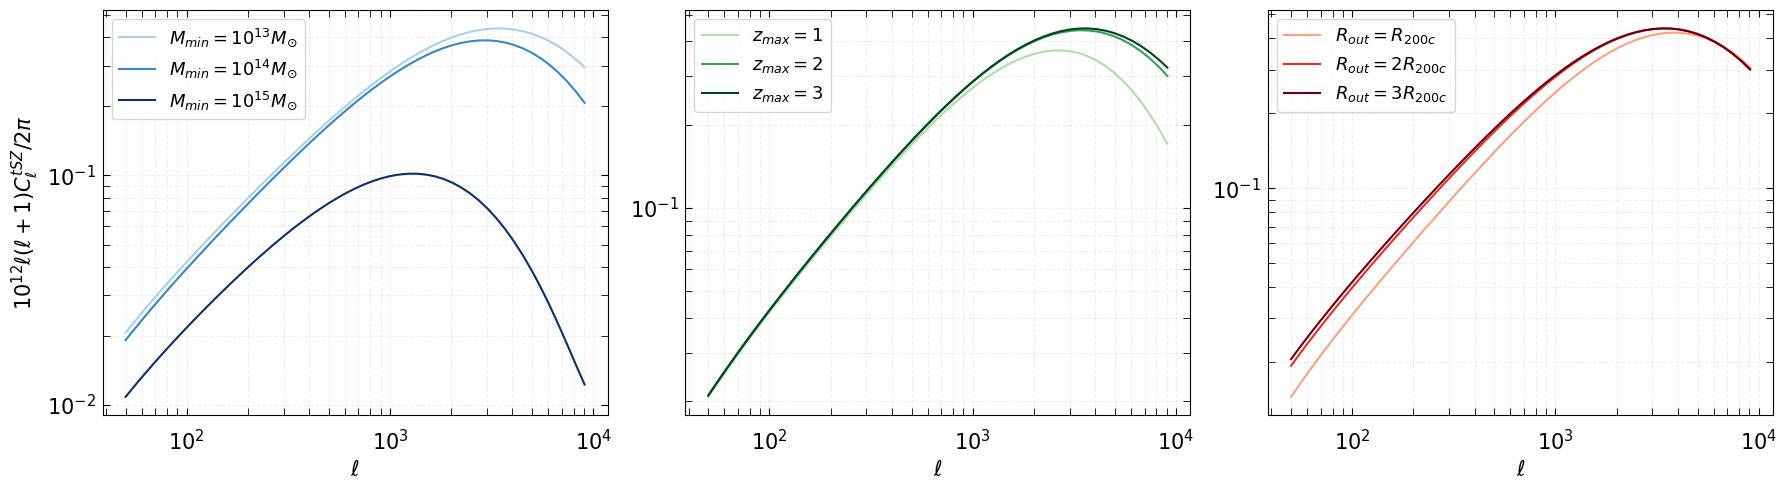

In [12]:
%%time
#some plot settings
import matplotlib as mpl

label_size = 15
title_size = 20
legend_size = 13
handle_length = 1.5

tot_color=12

norm1 = mpl.colors.Normalize(vmin=3, vmax=12)
cmap1 = mpl.cm.ScalarMappable(norm=norm1, cmap=mpl.cm.Blues)

norm2 = mpl.colors.Normalize(vmin=3, vmax=12)
cmap2 = mpl.cm.ScalarMappable(norm=norm2, cmap=mpl.cm.Greens)

norm3 = mpl.colors.Normalize(vmin=3, vmax=12)
cmap3 = mpl.cm.ScalarMappable(norm=norm3, cmap=mpl.cm.Reds)


fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(18,5))

# minimum masses
Mass_plot_labels=np.array([r'$M_{min}=10^{13}M_{\odot}$', r'$M_{min}=10^{14}M_{\odot}$', r'$M_{min}=10^{15}M_{\odot}$'])
Mass_params=np.array([1e13, 1e14, 1e15])


#minimum redshifts
redshift_plot_labels=np.array([r'$z_{max}=1$',r'$z_{max}=2$',r'$z_{max}=3$'])
redshift_params=np.array([1,2,3])

#maximum radii 
radii_plot_labels=np.array([r'$R_{out}=R_{200c}$',r'$R_{out}=2R_{200c}$',r'$R_{out}=3R_{200c}$'])
radii_params=np.array([1,2,3])

#plot settings
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.tick_params(axis = 'x',which='both',length=5,direction='in', pad=10)
ax1.tick_params(axis = 'y',which='both',length=5,direction='in', pad=5)
ax1.xaxis.set_ticks_position('both')
ax1.yaxis.set_ticks_position('both')
plt.setp(ax1.get_yticklabels(), rotation='horizontal', fontsize=label_size)
plt.setp(ax1.get_xticklabels(), fontsize=label_size)
ax1.grid( visible=True, which="both", alpha=0.2, linestyle='--')
ax1.set_xlabel(r'$\ell$', fontsize=label_size)
ax1.set_ylabel(r'$10^{12}\ell(\ell+1)C_{\ell}^{tSZ}/2\pi$', fontsize=label_size)

#varying Mmin
for i in range(len(Mass_params)):
    cl_yy_ell, cl_yy_tot=tSZ(Mmin=Mass_params[i])
    
    ax1.plot(cl_yy_ell, cl_yy_tot, label=Mass_plot_labels[i], c=cmap1.to_rgba(i*3+6))
ax1.legend(fontsize=legend_size)

#plot settings
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.tick_params(axis = 'x',which='both',length=5,direction='in', pad=10)
ax2.tick_params(axis = 'y',which='both',length=5,direction='in', pad=5)
ax2.xaxis.set_ticks_position('both')
ax2.yaxis.set_ticks_position('both')
plt.setp(ax2.get_yticklabels(), rotation='horizontal', fontsize=label_size)
plt.setp(ax2.get_xticklabels(), fontsize=label_size)
ax2.grid(visible=True, which="both", alpha=0.2, linestyle='--')
ax2.set_xlabel(r'$\ell$', fontsize=label_size)

#varying z_max
for j in range(len(redshift_params)):
    
    cl_yy_ell, cl_yy_tot=tSZ(zmax=redshift_params[j])

    ax2.plot(cl_yy_ell, cl_yy_tot, label=redshift_plot_labels[j], c=cmap2.to_rgba(j*3+6))
ax2.legend(fontsize=legend_size)

#plot settings
ax3.set_xscale('log')
ax3.set_yscale('log')
ax3.set_xscale('log')
ax3.set_yscale('log')
ax3.tick_params(axis = 'x',which='both',length=5,direction='in', pad=10)
ax3.tick_params(axis = 'y',which='both',length=5,direction='in', pad=5)
ax3.xaxis.set_ticks_position('both')
ax3.yaxis.set_ticks_position('both')
plt.setp(ax3.get_yticklabels(), rotation='horizontal', fontsize=label_size)
plt.setp(ax3.get_xticklabels(), fontsize=label_size)
ax3.grid(visible=True, which="both", alpha=0.2, linestyle='--')
ax3.set_xlabel(r'$\ell$', fontsize=label_size)

#varying xout
for k in range(len(radii_params)):
    
    cl_yy_ell, cl_yy_tot=tSZ(xout=radii_params[k])
    ax3.plot(cl_yy_ell, cl_yy_tot, label=radii_plot_labels[k],c=cmap3.to_rgba(k*3+6))
ax3.legend(fontsize=legend_size)

fig.tight_layout()
# plt.savefig('figures/tSZ_mass_z_radii.pdf')